In [44]:
import os

import pandas as pd
import numpy as np
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
from typing import Any, Optional, Union
from sklearn.calibration import LabelEncoder

# fix stupid pytorch error
import collections
collections.Iterable = collections.abc.Iterable


Dataset class:

In [45]:

class PandasDataset(Dataset):
    df: pd.DataFrame
    transforms: Optional[torchvision.transforms.Compose]
    def __init__(self, data_or_path: Union[pd.DataFrame,str], transforms: Optional[torchvision.transforms.Compose] = None):
        self.transforms = transforms
        if type(data_or_path) is str:
            self.df = self.__create_dataset__(data_or_path)
        else:
            self.df = data_or_path
        
    def __create_dataset__(self,path: str):
        images = []
        labels = []
        for label in os.listdir(path):
            for image in os.listdir(os.path.join(path,label)):
                images.append(os.path.join(path,label, image))
                labels.append(label)
        df = pd.DataFrame(
            data={
                'image_path': images,
                'label': labels
            }
        )
        df['encoded_label'] = LabelEncoder().fit_transform(df['label'])
        return df
        
    def shuffle(self):
        self.df = self.df.sample(frac = 1)
        return self
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        _id, image_path, _label, encoded_label = tuple(self.df.loc[index])


        image = Image.open(image_path)
        label = torch.tensor(encoded_label)
        if self.transforms is not None:
            image = self.transforms(image)

        return image, label
    
    def split(self, ratio: float = .7):
        train = []
        test = []
        for label in self.df['encoded_label'].unique():
            df = self.df[self.df['encoded_label'] == label ].sample(100)
            train_df = df.sample(frac=ratio)
            test_df = df[~df.index.isin(train_df.index)]

            train.append(train_df)
            test.append(test_df)
        
        train_ds = PandasDataset(pd.concat(train).reset_index(), transforms=self.transforms)
        test_ds = PandasDataset(pd.concat(test).reset_index(), transforms=self.transforms)

        return train_ds, test_ds
    def full_labels(self):
        return self.df[['label', 'encoded_label']].drop_duplicates().sort_values(by='encoded_label', axis=0).reset_index()
    def labels(self):
        return self.full_labels()['encoded_label'].values
    def label_names(self):
        return self.full_labels()['label'].values



In [ ]:
transformations = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize((.5,.5,.5),(.5,.5,.5))
])

batch_size = 4

train_set, test_set = PandasDataset('dataset.nogit/', transforms=transformations).split()

train_loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_set, batch_size, shuffle=True, num_workers=0)

label_names = train_set.label_names()
num_labels = len(label_names)



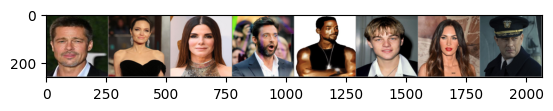

Brad Pitt, Angelina Jolie, Sandra Bullock, Hugh Jackman, Will Smith, Leonardo DiCaprio, Megan Fox, Tom Hanks


In [47]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(', '.join(f'{label_names[labels[j]]:5s}' for j in range(batch_size)))

In [48]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  # Convoluzione più piccola (3x3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, len(label_names))

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 256 -> 128
        x = self.pool(F.relu(self.conv2(x)))  # 128 -> 64
        x = self.pool(F.relu(self.conv3(x)))  # 64 -> 32
        x = self.pool(F.relu(self.conv4(x)))  # 32 -> 16
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    
net = Net()

In [49]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
history = []
for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    history.append({
        'loss': running_loss,
        'state': net.state_dict()
    })
    print(f"Epoch {epoch+1} has mean loss {running_loss:3}")
        # print statistics
        # if i % 10 == 9:    # print every 2000 mini-batches
        #     print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 10:.3f}')
        #     running_loss = 0.0
print('Finished Training')


Epoch 0 has mean loss 422.5313844680786
Epoch 1 has mean loss 422.46760511398315
Epoch 2 has mean loss 422.39864134788513
Epoch 3 has mean loss 422.34370255470276
Epoch 4 has mean loss 422.29752016067505
Epoch 5 has mean loss 422.26577067375183
Epoch 6 has mean loss 422.21795558929443
Epoch 7 has mean loss 422.16056632995605
Epoch 8 has mean loss 422.1049654483795
Epoch 9 has mean loss 422.04164934158325
Epoch 10 has mean loss 421.9734904766083
Epoch 11 has mean loss 421.85631108283997
Epoch 12 has mean loss 421.7012937068939
Epoch 13 has mean loss 421.52612113952637
Epoch 14 has mean loss 421.2113764286041
Epoch 15 has mean loss 420.63254833221436
Epoch 16 has mean loss 419.42426466941833
Epoch 17 has mean loss 415.7308051586151
Epoch 18 has mean loss 406.32598996162415
Epoch 19 has mean loss 393.7744793891907
Epoch 20 has mean loss 377.96150743961334
Epoch 21 has mean loss 363.6850347518921
Epoch 22 has mean loss 351.4314764738083
Epoch 23 has mean loss 341.89417827129364
Epoch 24 ha

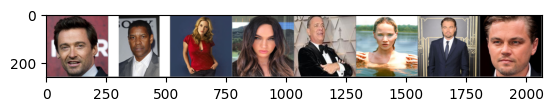

GroundTruth:  Hugh Jackman,Denzel Washington,Kate Winslet,Megan Fox,Tom Hanks,Jennifer Lawrence,Leonardo DiCaprio,Leonardo DiCaprio
Predicted:  Tom Cruise, Denzel Washington, Denzel Washington, Megan Fox, Nicole Kidman, Scarlett Johansson, Hugh Jackman, Kate Winslet


In [84]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ','.join(f'{label_names[labels[j]]:5s}' for j in range(batch_size)))
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ', '.join(f'{label_names[predicted[j]]:5s}'
                              for j in range(batch_size)))

In [ ]:
import sys
sys.getsizeof(net.state_dict())

1296